In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import pickle
import os.path

import qiskit
from qiskit import Aer
from qiskit import IBMQ
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.quantum_info import state_fidelity
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.circuit import Parameter

# some definitions of gate unitaries
s0 = np.array([[1,0],[0,1]])
sx = np.array([[0,1],[1,0]])
sy = np.array([[0,-1j],[1j,0]])
sz = np.array([[1,0],[0,-1]])
s = np.array([sx, sy, sz])
h = np.array([[1,1],[1,-1]])/np.sqrt(2)

# number of qubits in the quantum circuit
n_qubits = 5

In [2]:
# some helpful functions

# get_bin converts an integer x to a binary number with (n_qubits-1) bits, i.e. get_bin(3) -> '011' 
get_bin = lambda x, n=(n_qubits-1): format(x, 'b').zfill(n)

def ret(dictionary, key):
    if key in dictionary:
        return dictionary[key]
    else:
        return 0
def next_file(filename, file_extension="pdf", folder="figures", replace_last=True):
    """
    Return another filename with increased index. If files '0_filename.pdf' and '1_filename.pdf' already exist, 
    and if replace_last=False, this function will return '2_filename.pdf'. In the case, where replace_last=True,
    it will return the last existing filename, i.e. '1_filename.pdf' in above example.
    """
    idxx = 0
    while(True):
        ff = f"{folder}/{idxx}_{filename}.{file_extension}"
        if not os.path.exists(ff):
            break
        idxx += 1
    if replace_last and idxx > 0:
        ff = f"{folder}/{idxx-1}_{filename}.{file_extension}"
    return ff

In [3]:
IBMQ.load_account()

provider = IBMQ.get_provider(group='open')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_london') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_burlington') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_essex') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>]

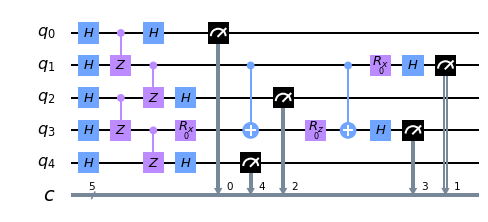

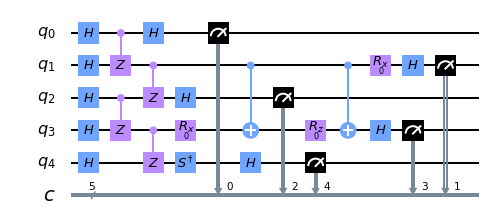

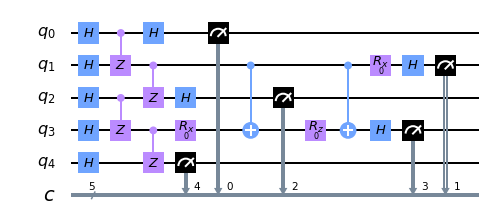

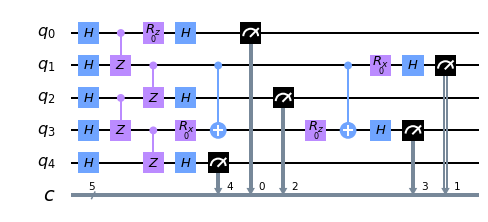

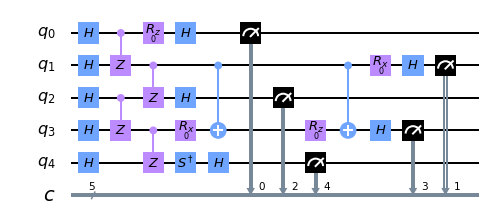

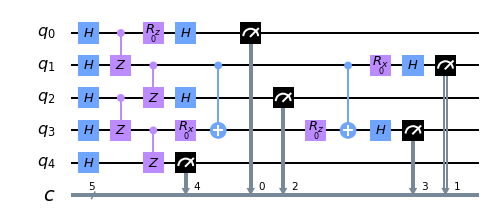

In [9]:
# the range of parameters (alpha) to consider
alphas = np.linspace(0,2*np.pi,25)

# two different sets of data, one for symmetry preserving perturbtions and one for symmetry breaing perturbation
sets=[True,False]
n_sets = len(sets)
submit = [] # this list will store all circuits
psi_in = np.zeros(2)
symstring = ["",""]

# measurement circuit of all but the last qubit
# everything is measured in x-basis
m = QuantumCircuit(n_qubits,n_qubits)
for i in np.arange(n_qubits-1):
    m.h(i)
m.measure(range(n_qubits-1),range(n_qubits-1))

# tomography on the last qubit, i.e. measurement along x,y,z
mz = QuantumCircuit(n_qubits,n_qubits)
mz.measure(n_qubits-1,n_qubits-1)

mx = QuantumCircuit(n_qubits,n_qubits)
mx.h(n_qubits-1)
mx.measure(n_qubits-1,n_qubits-1)

my = QuantumCircuit(n_qubits,n_qubits)
my.sdg(n_qubits-1)
my.h(n_qubits-1)
my.measure(n_qubits-1,n_qubits-1)

# define the main circuit for different symmetry in [True,False]
# and for all alphas
# THIS PART HAS TO BE ADJUSTED IF THE NUMBER OF QUBITS n_qubits IS CHANGED
for symmetry in sets:
    for alpha in alphas: 
        circuit = QuantumCircuit(n_qubits,n_qubits)

        # define initial state 
        psi_in = np.array([1,1])/np.sqrt(2)

        for i in np.arange(n_qubits):
            circuit.h(i)
        circuit.cz(0,1)
        circuit.cz(2,3)
        circuit.cz(1,2)
        circuit.cz(3,4)

        ###############################
        # unitary goes in here
        ###############################
        circuit.rx(alpha,3)
        circuit.cnot(1,3)
        circuit.rz(alpha, 3)
        circuit.cnot(1,3)
        circuit.rx(alpha,1)
        
        # description the symmetry preserving unitary, this string is printed as a plotlabel
        symstring[0] = r"$R_x(\alpha)_4 exp(i\alpha Z_2 Z_4) R_x(\alpha)_2$"

        if not symmetry:
            circuit.rz(alpha,0)
            # description of the symmetry breaking unitary
            symstring[1] = symstring[0] + r" $R_z(\alpha)_1$"
        ##############################
        ##############################

        submit.append(circuit+m+mx)
        submit.append(circuit+m+my)
        submit.append(circuit+m+mz)


def drawcircuits(circuits, selected):
    for i in selected:
        f1 = plt.figure(); ax = f1.add_subplot(111);
        circuits[i].draw(idle_wires=False, output='mpl',scale=0.5, ax=ax)
        
# print somce circuits to see if everything is implemented correctly
# choose first 3 circuits of first half (symmetry preserving, alpha=0)
# and choose first 3 circuits of second half (symmetry brealing, alpha=0)
print_selected = [0,1,2,len(submit)//2,len(submit)//2+1,len(submit)//2+2] 
drawcircuits(submit, print_selected)

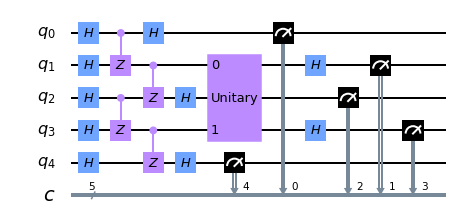

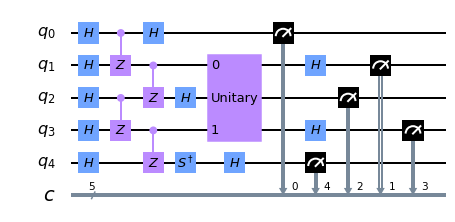

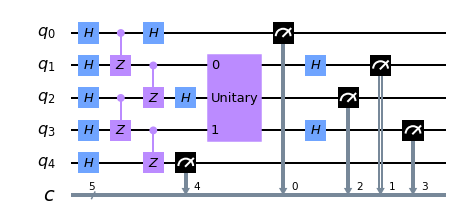

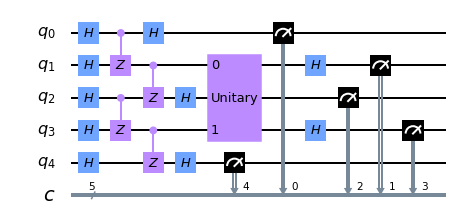

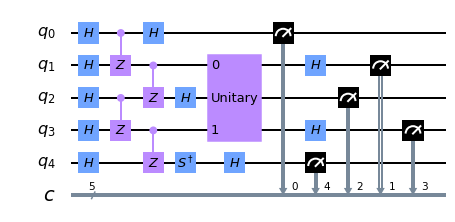

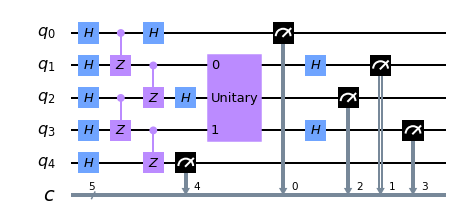

In [24]:
#qc='ibmq_16_melbourne'
#qc='ibmqx2'
qc = 'ibmq_qasm_simulator'
olevel = 3
nshots = 8192//2
namestring = str(len(alphas)) + qc + " " + str(n_qubits) + f" OL {olevel}, |+>, {nshots} shots"
initial_layout=[0,1,2,3,4] # define mapping of virtual qubits to pysical qubits

sim_backend = provider.get_backend(qc)
submit_t = transpile(submit, backend=sim_backend,optimization_level=olevel, initial_layout=initial_layout)

# print to check the transpiled circuit
# for alpha = alphas[0]
print_figs = [0,1,2,len(submit_t)//2,len(submit_t)//2+1,len(submit_t)//2+2]
for i in print_figs:
    f1 = plt.figure(); ax = f1.add_subplot(111);
    submit_t[i].draw(idle_wires=False, output='mpl',scale=0.5, ax=ax)

In [25]:

replace_last = False        
# I use the jobmanager to submit all jobs necessary to create one figure at once. this will automatically split up
# submit_t, that contains all transpiled circuits, into jobs of 75 circuits each. The maximum number of allowed jobs 
# in the queue is 5, which amounts to 5*75=375 circuits. Once should make sure than n_sets*len(alphas)*3 is less than 375
job_manager = IBMQJobManager()
job_exp = job_manager.run(submit_t, backend=sim_backend, name=namestring, shots=nshots, max_experiments_per_job=75,optimization_level=olevel)
for j in np.arange(len(job_exp.jobs())):
    job_monitor(job_exp.jobs()[j])
result = job_exp.results()
"""

job_exp = qiskit.execute(submit_t, Aer.get_backend('qasm_simulator'), shots=nshots)
result = job_exp.result()
#""";

Job Status: job has successfully run
Job Status: job has successfully run


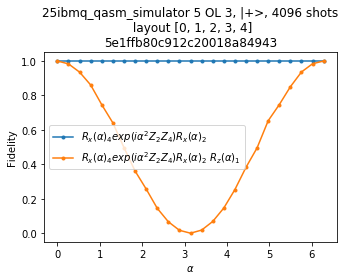

In [28]:
f_avg = np.zeros((n_sets,len(alphas)), dtype=complex)
p_avg = np.zeros((n_sets,len(alphas)), dtype=complex)

plt.figure(figsize=(5,4))
for j in np.arange(n_sets):
    for a in np.arange(len(alphas)):
        FF = np.zeros((n_qubits-1)**2, dtype=complex)
        PP = np.zeros((n_qubits-1)**2, dtype=complex)
        tot = np.zeros(((n_qubits-1)**2, 3))
        for i in np.arange((n_qubits-1)**2):
            # the first (n_qubits-1) qubits are all measured in x basis
            # the pauli corrections will be different depending on the measurement outcomes
            # we therefor loop through all of the (n_qubits-1)**2 different outcomes
            
            # arrays store measurements of |0> and |1> for all three axes
            up = np.zeros(3)
            down = np.zeros(3)

            # convert i to binary and extracted results s1, s2, ... 
            binary = get_bin(i);
            s1 = int(get_bin(i)[-1])
            s2 = int(get_bin(i)[-2])
            s3 = int(get_bin(i)[-3])
            s4 = int(get_bin(i)[-4])

            # perform pauli corrections on the input state psi_in 
            # to get the expected output state psi_out
            psi_out = np.copy(psi_in)
            for aa in np.arange(s2+s4):
                psi_out = sx.dot(psi_out)
            for aa in np.arange(s1+s3):
                psi_out = sz.dot(psi_out)

            # perform quantum state tomography on the last qubit
            rho_exp = 0.5 * np.array(s0, dtype= complex)
            for axis in np.arange(3):
                r = result.get_counts(int(j*3*len(alphas) + 3*a + axis))
                up[axis] += ret(r,'0'+binary) 
                down[axis] += ret(r,'1'+binary)
                tot[i, axis] = up[axis] + down[axis]

                if tot[i, axis] > 0:
                    rho_exp += 0.5 * (up[axis]-down[axis])/tot[i, axis] * s[axis]
            
            # compute the fidelity for that particular case of s1, s2, ... outcomes
            FF[i] = state_fidelity(psi_out, rho_exp)
            PP[i] = np.trace(rho_exp@rho_exp) # also compute purity (ideally it should be 1, since state is pure)
        # average the fidelities obtained for each different outcome of s1, s2, ...
        # here I am weighting the fidelities by how often the specific outcome s1, s2,... occurred
        # I think weighting makes sense, since if the outcome s1, s2,... was rare, we can't really trust 
        # the extracted density matrix, but please let me know if you disagree, Daniel
        total = np.sum(tot, axis=1)
        f_avg[j,a] = np.sum(FF*total) / np.sum(total)
        p_avg[j,a] = np.mean(PP)

    plt.plot(alphas, f_avg[j].real, '.-', label=symstring[j])
plt.title(namestring + f"\n layout " + str(initial_layout) + f"\n{job_exp.jobs()[0].job_id()}")
plt.xlabel(r"$\alpha$")
plt.ylabel("Fidelity")
plt.legend()
plt.tight_layout()

# save all figures to new file (or replace last file if replace_last=True)
# the job_id in the plot title allows us to retrieve the data from the IBM server to replot the figure in high quality
plt.savefig(next_file("sim", file_extension="pdf", replace_last=replace_last))
plt.savefig(next_file("sim", file_extension="jpg", replace_last=replace_last))
submit[0].draw(output='mpl', filename=next_file("a_sim",file_extension="png", replace_last=replace_last))
submit[len(submit)//2].draw(output='mpl', filename=next_file("b_sim",file_extension="png", replace_last=replace_last))
submit_t[0].draw(output='mpl', idle_wires=False, filename=next_file("a_transpiled",file_extension="png", replace_last=replace_last))
submit_t[len(submit_t)//2].draw(output='mpl', idle_wires=False, filename=next_file("b_transpiled",file_extension="png", replace_last=replace_last))
replace_last = True